#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


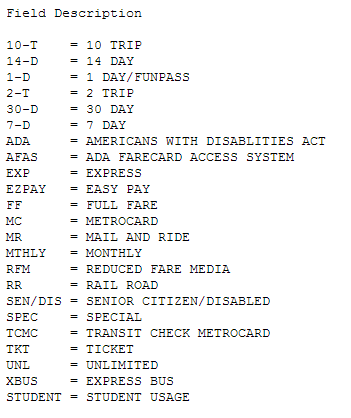

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [2]:
import numpy as np
data = np.load('MTA_Fare.npy')
data = data.astype(float)
def replaceNoData3D(scanBlock, NDV):
    for n1, sB1 in enumerate(scanBlock):
        for n2, sB2 in enumerate(sB1):
            for n3, elem in enumerate(sB2):
                if elem == NDV:
                    scanBlock[n1][n2][n3] = np.nan
replaceNoData3D(data,-1.0)

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

Populating the interactive namespace from numpy and matplotlib


(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

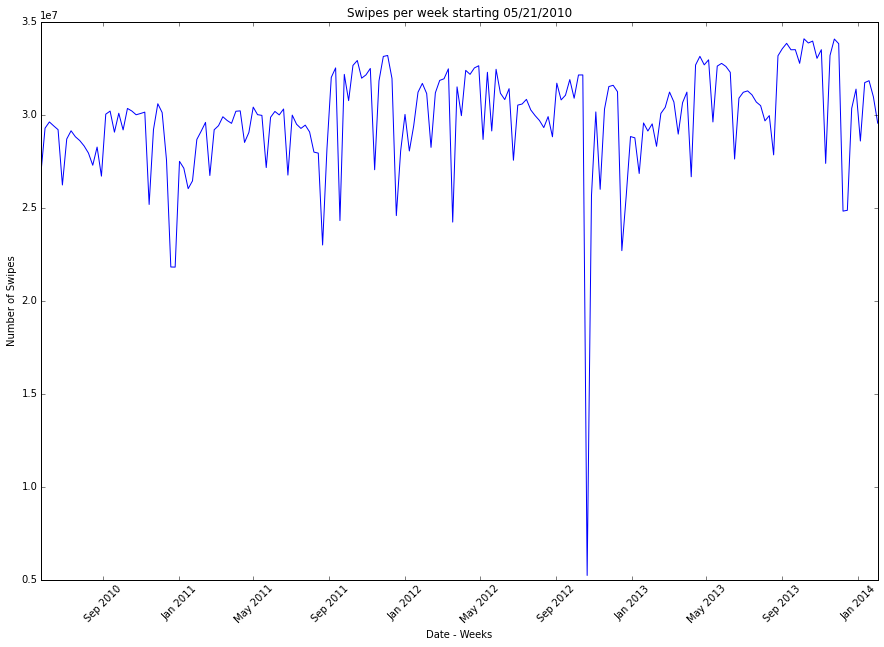

In [3]:
events = np.nansum(data,axis=(0,1))
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%pylab inline
weeks = pd.date_range(start='2010-05-21',periods=194,freq='W')
plt.figure(figsize=(15,10))
plt.plot_date(x=weeks, y=events,fmt='-')
plt.xlabel('Date - Weeks')
plt.ylabel('Number of Swipes')
plt.title('Swipes per week starting 05/21/2010')
plt.xticks(rotation=45)

In [4]:
#Now calculation upper and lower thresholds in arrays, mean + 3 sigma 
UpThhevent = events.mean() + 3 * events.std()
LowThhevent = events.mean() - 3 * events.std() 
#Now Calculate Period of Time where it occured
Lowweeks = np.where(events < LowThhevent) 
print weeks[Lowweeks[0][0]]

2012-10-21 00:00:00


# There is a very significant drop between October 2012 and November 2012, due to Hurricane Sandy. 
# It was from october 22nd to November 2nd, 2012.

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a41a650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bb28410>]], dtype=object)

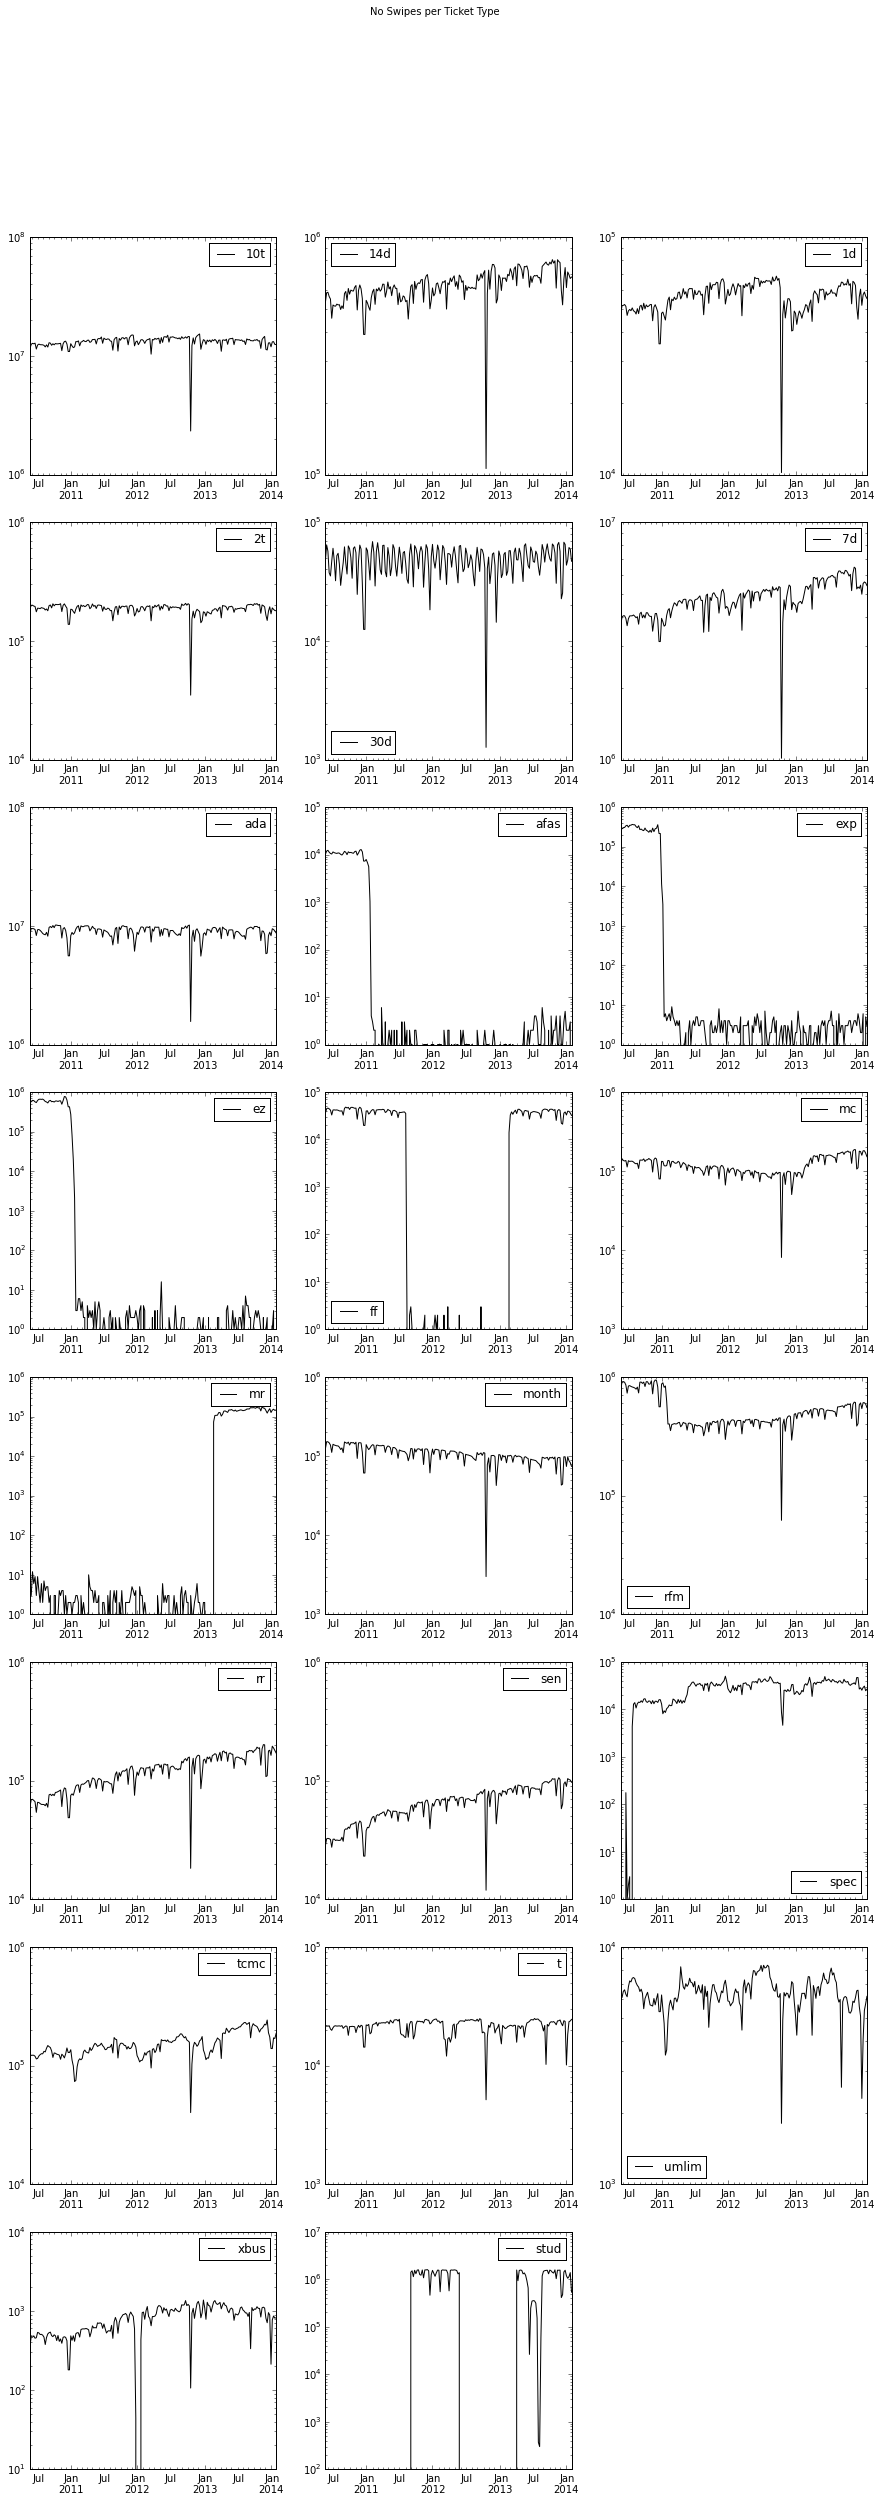

In [5]:
# Defining the type of rides
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
#Create a 23x194 array, having in each cell the sum of all stations
#fig, axes = plt.subplots(nrows=8, ncols=3)
perWeek = pd.DataFrame(np.nansum(data,axis=0),index=ridetype).transpose()
perWeek.plot(figsize=(15,40),x=weeks,logy=True,subplots=True,sharey=False,sharex=False,layout=(8,3),title='No Swipes per Ticket Type')




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1048bd550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113a90e90>]], dtype=object)

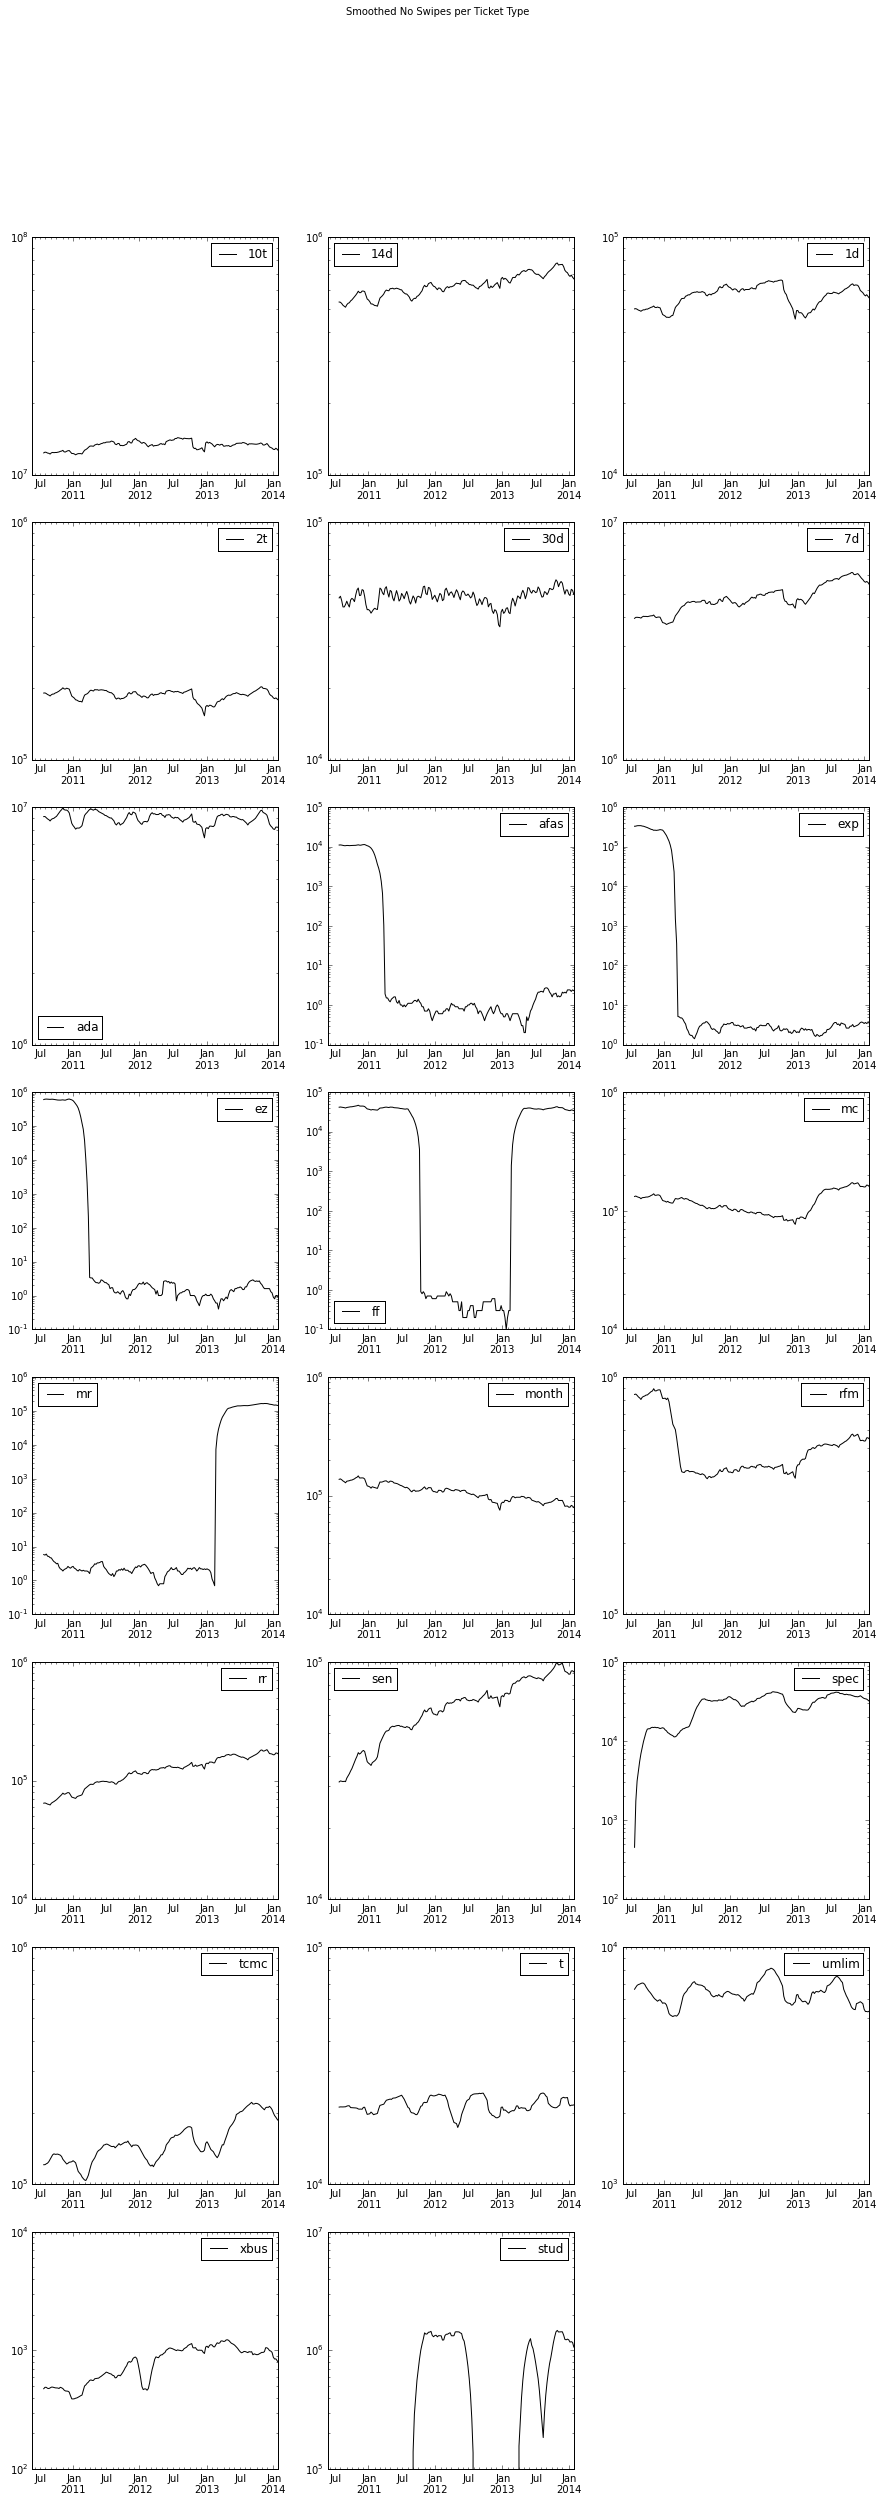

In [6]:
#Plotting smooth time series
SmoothperWeek = pd.rolling_mean(perWeek, 10)
SmoothperWeek.plot(figsize=(15,40),x=weeks,logy=True,subplots=True,sharey=False,sharex=False,layout=(8,3),title='Smoothed No Swipes per Ticket Type')


In [7]:
#check ratio for first 10 weeks with 10 last weeks
ratio = log10(SmoothperWeek.loc[0:9,:].mean()/SmoothperWeek.loc[185:194,:].mean())
print ratio

10t     -0.019452
14d     -0.119060
1d      -0.064870
2t       0.015134
30d     -0.025464
7d      -0.160873
ada      0.040672
afas     3.689545
exp      4.968394
ez       5.718991
ff       0.068608
mc      -0.087425
mr      -4.416829
month    0.225437
rfm      0.189609
rr      -0.417728
sen     -0.464563
spec    -1.883937
tcmc    -0.218570
t       -0.023118
umlim    0.075635
xbus    -0.280259
stud         -inf
dtype: float64


In [8]:
#Select all of them which have a significant ratio
10**ratio[(ratio >= 0.3) | (ratio <= -0.3)] #more than 2 (or less than half)

afas      4892.658416
exp      92980.987382
ez      523589.155340
mr           0.000038
rr           0.382184
sen          0.343113
spec         0.013064
stud         0.000000
dtype: float64

There are 8 values who changes more than 2 (or less than half) listed above, and the ratios. The extremes are: 'ez' which is greater by 523,589.15 times and 'stud' which reduces to 0

#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [9]:
#We have to use Fourier Transform to find how much each periodicity contribute to the time series
perStations = np.nansum(data, axis=1)
yfreq = np.abs(np.fft.rfft(perStations))
#weeks periodicity 
xfreq = np.fft.rfftfreq(194, d=1.0)
#find the column that is closer to frequency 1/52 (annual)
idxAnnual = np.where(min(abs(xfreq - 1.0/52)) == abs(xfreq - 1.0/52))[0][0]
print idxAnnual

4


In [10]:
#Find the 4 with bigger values
select1 = np.argpartition(yfreq[:,idxAnnual], -4)[-4:]
print select1

[327 150 194   0]


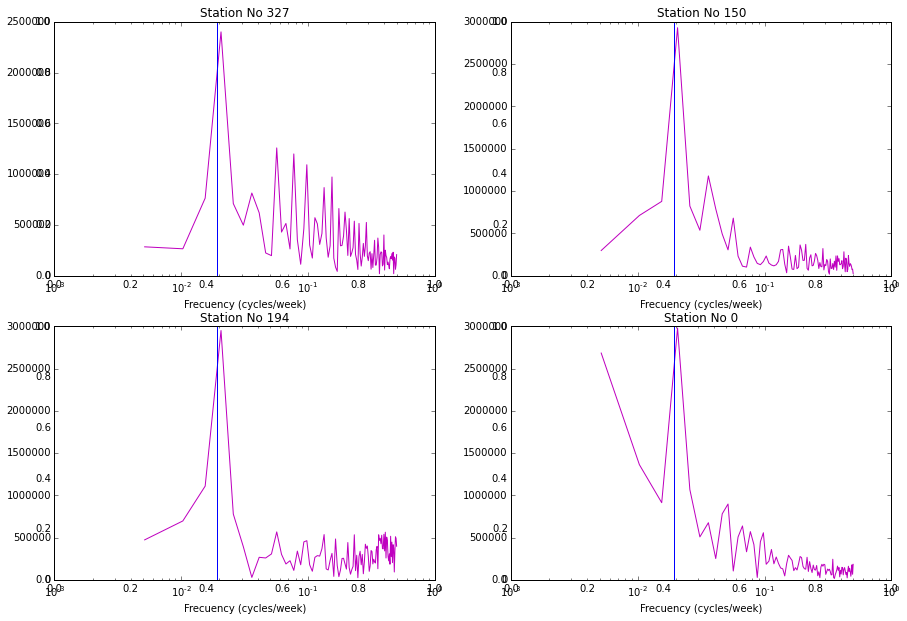

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.figure(figsize(15,10))
for n,i in enumerate(select1):
    ax = fig.add_subplot(2,2,n+1)
    f = np.abs(np.fft.rfft(perStations[i,:])).transpose()
    ax.set_title("Station No %s" %(i))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'm-')
    ax.set_xscale('log')
    ax.axvline(1.0/52)
    ax.set_xlabel('Frecuency (cycles/week)')
plt.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

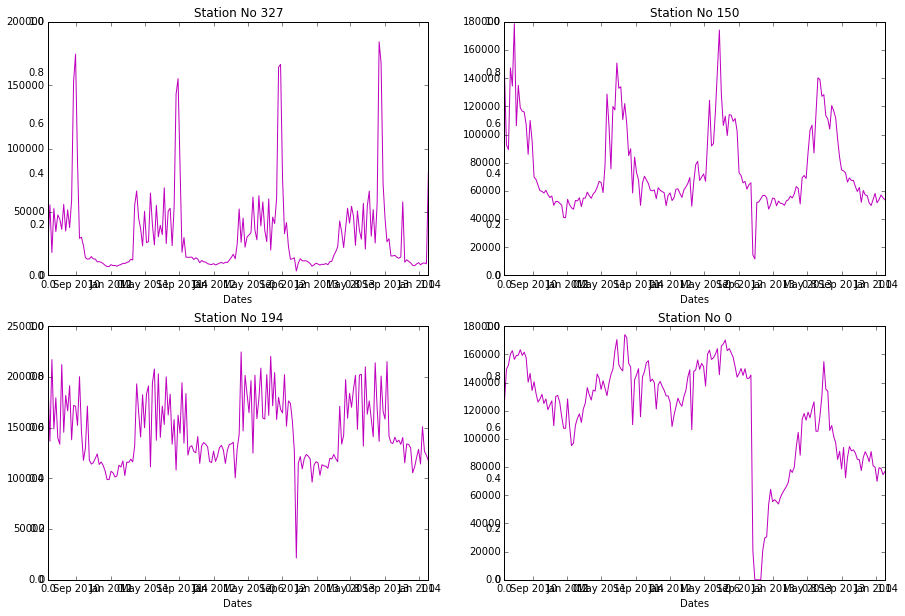

In [12]:
#Plotting Time Series per Station
fig2, ax2 = plt.subplots(nrows=2, ncols=2)
plt.figure(figsize(15,10))
for n,i in enumerate(select1):
    ax2 = fig2.add_subplot(2,2,n+1)
    x = perStations[i,:]
    ax2.set_title("Station No %s" %(i))
    ax2.plot(weeks, x, 'm-')
    ax2.set_xlabel('Dates')
plt.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

# This stations are those that have he most prominent annual periodicity, so I think it is due the seasons.